In [1]:
import pandas as pd
import pymc3 as pm
import math
import numpy as np
import scipy as sp
from scipy.stats import gamma
import matplotlib.pyplot as plt

%matplotlib inline

# Measurement Error in Causal Inference 

In this notebook, we'll explore the scenario of finding a causal effect of a treatment on an outcome.  We consider the case of when we have confounding but the confounding variable itself is latent; what we have instead is a noisy measurement of the latent variable. In the following fictitious example, we are interested in finding the causal effect of Tutoring $T$ on graduation rate $G$.

<img alt="Causal Diagram with Measurement Error on Unobserved Confounder" src="./img/dag.png" width="700px">


Let's say that richer people are more likely to take $T$ than their poorer counterparts. Richer people have more means to spend on education. Likewise, those with higher socioeconomic status have an easier time graduating because of socioeconomic status itself. In other words, socioeconomic status ($S$) is a common cause of treatment and outcome. For this experiment, we'll assume a toy problem -- we assume that the only cause of $T$ is $S$. We also assume that we have access to $F$, which is a proxy for $S$. We'll assume we know the population parameters apriori and generate a data set given those population parameters and see if we could recover the causal effect of $T$ on $G$. 

We consider several scenarios:

1. We do a naive analysis and simply find the means of differences for those who got tutoring vs. those who didn't get tutoring.
2. We adjust for the proxy variable ($F$) without directly adjusting for the latent confounding variable.
3. We directly adjust for the confounding variable ($S$) (as if it was observed).
2. We make use of the true Directed Acyclic Graph (DAG) and assign sensible priors to the latent confounding variable.

We'll use PyMC3, a Bayesian inference library, to infer parameters of interest.

## Pre-Experiment Beliefs

Looking at the graph, there's a backdoor path $T \leftarrow S \rightarrow G$, that, when unblocked, transmits spurious association between $T$ and $G$. For time-fixed treatments, the Adjustment/Standardization formula would say that we could get an unbiased estimate of the effect of $T$ on $G$ as follows:

$$
\begin{equation}
\begin{aligned}
  P(g \mid do(t)) &= \sum_{s} P(g \mid t, s) \cdot P(s)
\end{aligned}
\end{equation}
$$

#1 does not adjust for $s$, so I suspect that it will give biased results. #2 adjusts for a noisy measurement of $s$. It doesn't fully adjust for socioeconomic status so there still might be [residual confounding](http://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704-EP713_Confounding-EM/BS704-EP713_Confounding-EM4.html) so our results might still have bias. #3 should have little to no bias since it uses the Adjustment/Standardization formula. I'm not sure how #4 would turn out, so let's find out!


## Post-Experiment Beliefs
TODO

However, in some data sets, we might not have access to $S$, but we might have access to a proxy. In our fictitious example, we might have access to something like Free/Reduced Lunch $F$. 

## Generate Synthetic Dataset

### Socioeconomic Status

Let's say socioeconomic status is defined as household income. In reality, household income is just a measure of socioeconomic status, since it doesn't take into account inheritance -- one could technically be wealthy while having 0 household income. However, for the sake of simplicity of this experiment, we'll equate household income with socioeconomic status.

Here's an example household income distribution from [statisticalatlas.com](https://statisticalatlas.com/state/Massachusetts/Household-Income):

![Household Income](./img/household-incomes.png)

We could model household income for people in Massachusetts as a [gamma distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html). I thought of using the gamma distribution after looking at this graph because 

1. Household income is continuous. 
2. The lower bound of income is 0.
3. Household income distribution is skewed towards the left.
4. Some people have really high incomes relative to most.

Here's a model of income:

In [2]:
with pm.Model() as socioecon_model:
    pm.Gamma('socioecon', alpha=1.49, beta=2.04)
    socioecon_prior = pm.sample_prior_predictive(samples=2000)

Above is a model of income, inspired by the household income percentiles graph of Massachusetts. 1 unit in the gamma model of the socioeconomic status corresponds to \$100,000 in income.

Text(0.5, 0, 'income (in hundred thousands $)')

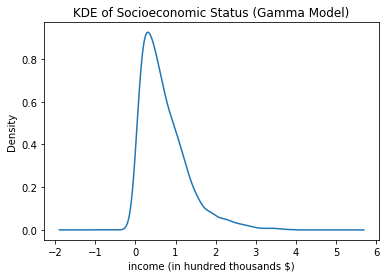

In [3]:
df_dict = {}
df_dict['socioeconomic_status'] = pd.Series(socioecon_prior['socioecon'])
ax = df_dict['socioeconomic_status'].plot.kde(title='KDE of Socioeconomic Status (Gamma Model)')

ax.set_xlabel('income (in hundred thousands $)')

Below, we scale the socioeconomic status variable for later processing.

In [4]:
socioecon_scaler = 3.55
df_dict['socioeconomic_status_scaled'] = df_dict['socioeconomic_status'] / socioecon_scaler

### Generate Treatment

Let's say that richer people are more likely to receive tutoring.

In [5]:
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

In [45]:
true_values = {}
true_values['tutoring_alpha'] = -0.3
true_values['socioecon_to_tutoring_coeff'] = -2

In [84]:
df_dict['tutoring'] = np.random.binomial(
    n=1,
    p=logistic(
        df_dict['socioeconomic_status_scaled'] * true_values['socioecon_to_tutoring_coeff'] + true_values['tutoring_alpha']
    )
)

### Generate Outcome

We'll assume that wealthy students are more likely to graduate. We'll also assume that getting tutored, on average, increases the probability of graduating by some amount.

In [85]:
true_values['tutoring_to_grad_coeff'] = 1
true_values['socioecon_to_grad_coeff'] = 3
true_values['grad_alpha'] = -1
df_dict['graduation'] = np.random.binomial(
    n=1, 
    p=logistic(
        df_dict['tutoring'] * true_values['tutoring_to_grad_coeff'] + \
        df_dict['socioeconomic_status_scaled'] * true_values['socioecon_to_grad_coeff'] + \
        true_values['grad_alpha']
    )
)

### Generate Free/Reduced Lunch

We'll have a simple rule: If income is less than \$35,000, then student has free/reduced lunch.

In [86]:
df_dict['free_reduced_lunch'] = (df_dict['socioeconomic_status'] < 0.35) * 1

In [87]:
df_dict['free_reduced_lunch'].mean()

0.3005

### Plotting code

Below is code for plotting prior and posterior distributions.

In [88]:
def plot(
    prior_or_posterior, 
    title,
    true_values, 
    plottables=['socioecon_to_tutoring_coeff', 'tutoring_alpha', 'tutoring_to_grad_coeff', 'socioecon_to_grad_coeff', 'grad_alpha']
):

    num_cols = 2
    num_rows = math.ceil(float(len(plottables)) / num_cols)
    fig, ax = plt.subplots(num_rows, num_cols)

    
    for index, plottable in enumerate(plottables):
            
        row_index = int(index / num_cols)
        col_index = int(index % num_cols)
        
        if num_rows > 1:
            axis = ax[row_index, col_index]
        else:
            axis = ax[index]

        
        true_value = true_values[plottable]
        
        pd.Series(prior_or_posterior[plottable]).plot.kde(
            title=plottable, 
            ax=axis,
            xlim=(-5,5)
        )
        
        axis.axvline(x=true_value, color='r')
    plt.tight_layout()
    
        
    fig.suptitle(title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [89]:
df = pd.DataFrame(df_dict)

In [90]:
df.shape

(2000, 5)

## Create Models

In [91]:
def plot_posterior(traces, varnames, true_values):
    axes = pm.plot_posterior(traces, varnames=varnames)
    for index, varname in enumerate(varnames):
        axes[index].axvline(true_values[varname])

### Confounder Observed
Below, we suppose that socioeconomic and free/reduced-lunch status are both observed:

In [92]:
with pm.Model() as model_with_socioecon_status_and_frpl_observed:
    gamma_alpha = 1.49
    gamma_beta = 2.04
    
    tutoring_to_grad_coeff = pm.Normal('tutoring_to_grad_coeff', mu=true_values['tutoring_to_grad_coeff'], sigma=0.75)
    socioecon_to_grad_coeff = pm.Normal('socioecon_to_grad_coeff', mu=true_values['socioecon_to_grad_coeff'], sigma=0.75)
    socio_to_tutoring_coeff = pm.Normal('socioecon_to_tutoring_coeff', mu=true_values['socioecon_to_tutoring_coeff'], sigma=0.75)
    tutoring_alpha = pm.Normal('tutoring_alpha', mu=true_values['tutoring_alpha'], sigma=0.75)
    grad_alpha = pm.Normal('grad_alpha', mu=true_values['grad_alpha'], sigma=0.75)
    
    socioeconomic_status = pm.Gamma(
        'socioeconomic_status', 
        alpha=gamma_alpha, 
        beta=gamma_beta, 
        observed=df['socioeconomic_status'] # Socioeconomic Status is Observed
    )
    p_tutoring = logistic(socioeconomic_status / socioecon_scaler * socio_to_tutoring_coeff + tutoring_alpha)

    tutoring = pm.Binomial('tutoring', n=1, p=p_tutoring, observed=df['tutoring'], shape=df.shape[0])

    p_graduation = logistic(tutoring * tutoring_to_grad_coeff + socioeconomic_status / socioecon_scaler * socioecon_to_grad_coeff + grad_alpha)
    graduation = pm.Binomial('graduation', n=1, p=p_graduation, observed=df['graduation'])
    # p_free_reduced_lunch = pm.math.switch(pm.math.le(socioeconomic_status, 35000), 0.99, 0.01)
    p_free_reduced_lunch = logistic(25 * (0.35 - socioeconomic_status))

    pm.Binomial(
        'free_reduced_lunch', 
        n=1, 
        p=p_free_reduced_lunch, 
        observed=df['free_reduced_lunch'] # Free reduced lunch is observed
    )
    
    sample_prior_predictive_socio_and_frpl_observed = pm.sample_prior_predictive(samples=2000)
    traces_socio_and_frpl_observed = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [grad_alpha, tutoring_alpha, socioecon_to_tutoring_coeff, socioecon_to_grad_coeff, tutoring_to_grad_coeff]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:07<00:00, 802.78draws/s]


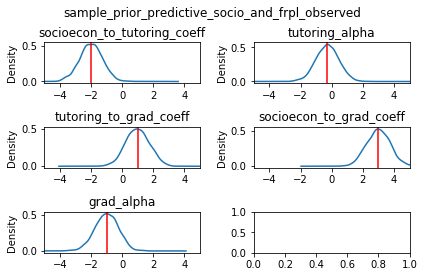

In [93]:
plot(prior_or_posterior=sample_prior_predictive_socio_and_frpl_observed, true_values=true_values, title="sample_prior_predictive_socio_and_frpl_observed")

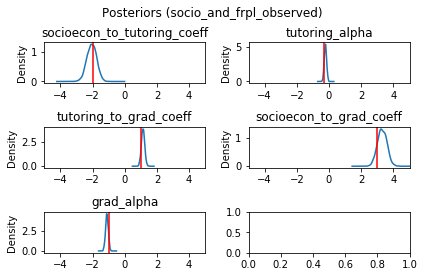

In [94]:
plot(prior_or_posterior=traces_socio_and_frpl_observed, true_values=true_values, title="Posteriors (socio_and_frpl_observed)")

In [95]:
with pm.Model() as model_with_measurement_error:
    gamma_alpha = 1.49
    gamma_beta = 2.04
    
    tutoring_to_grad_coeff = pm.Normal('tutoring_to_grad_coeff', mu=true_values['tutoring_to_grad_coeff'], sigma=0.75)
    socioecon_to_grad_coeff = pm.Normal('socioecon_to_grad_coeff', mu=true_values['socioecon_to_grad_coeff'], sigma=0.75)
    socio_to_tutoring_coeff = pm.Normal('socioecon_to_tutoring_coeff', mu=true_values['socioecon_to_tutoring_coeff'], sigma=0.75)
    tutoring_alpha = pm.Normal('tutoring_alpha', mu=true_values['tutoring_alpha'], sigma=0.75)
    grad_alpha = pm.Normal('grad_alpha', mu=true_values['grad_alpha'], sigma=0.75)
    
    socioeconomic_status = pm.Gamma(
        'socioeconomic_status', 
        alpha=gamma_alpha, 
        beta=gamma_beta, 
        shape=df.shape[0]
    )
    p_tutoring = logistic(socioeconomic_status / socioecon_scaler * socio_to_tutoring_coeff + tutoring_alpha)

    tutoring = pm.Binomial('tutoring', n=1, p=p_tutoring, observed=df['tutoring'], shape=df.shape[0])

    p_graduation = logistic(tutoring * tutoring_to_grad_coeff + socioeconomic_status / socioecon_scaler * socioecon_to_grad_coeff + grad_alpha)
    graduation = pm.Binomial('graduation', n=1, p=p_graduation, observed=df['graduation'])
    
    p_free_reduced_lunch = logistic(25 * (0.35 - socioeconomic_status))

    pm.Binomial(
        'free_reduced_lunch', 
        n=1, 
        p=p_free_reduced_lunch, 
        observed=df['free_reduced_lunch']
    )
    
    sample_prior_predictive_with_measurement_error = pm.sample_prior_predictive(samples=2000)
    traces_with_measurement_error = pm.sample(tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [socioeconomic_status, grad_alpha, tutoring_alpha, socioecon_to_tutoring_coeff, socioecon_to_grad_coeff, tutoring_to_grad_coeff]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:49<00:00, 120.45draws/s]


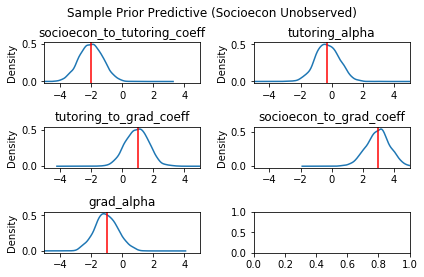

In [96]:
plot(prior_or_posterior=sample_prior_predictive_with_measurement_error, title='Sample Prior Predictive (Socioecon Unobserved)', true_values=true_values)

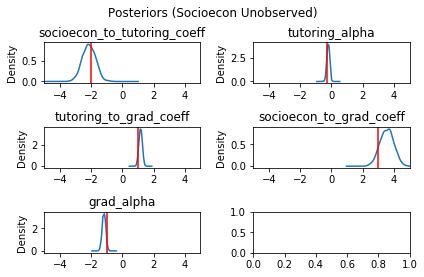

In [97]:
plot(prior_or_posterior=traces_with_measurement_error, title='Posteriors (Socioecon Unobserved)', true_values=true_values)

## Comparisons

### True Effect of Tutoring on the Population

Intervening on tutoring is represented by removing the arrows that go into the $Tutoring$ variable.

TODO: Why is the unadjusted effect estimate essentially the same as the correct adjusted effect estimate?

In [98]:

difference = logistic(
        1 * true_values['tutoring_to_grad_coeff'] +
        df_dict['socioeconomic_status_scaled'] * true_values['socioecon_to_grad_coeff'] + \
        true_values['grad_alpha']
    ) - logistic(
        0 * true_values['tutoring_to_grad_coeff'] +
        df_dict['socioeconomic_status_scaled'] * true_values['socioecon_to_grad_coeff'] + \
        true_values['grad_alpha']
    )

avg_effect_of_tutoring_on_grad_rates = difference.mean()

print("The average effect of tutoring on graduation rates is", round(avg_effect_of_tutoring_on_grad_rates * 100, 2) , "percentage points.")

The average effect of tutoring on graduation rates is 23.33 percentage points.


In [99]:
df[df['tutoring'] == 1]['graduation'].mean() - df[df['tutoring'] == 0]['graduation'].mean()

0.22847616942618149

In [100]:
df[['tutoring', 'socioeconomic_status']].corr()

,tutoring,socioeconomic_status
tutoring,1.000000,-0.142329
socioeconomic_status,-0.142329,1.000000


In [101]:
traces_with_measurement_error.varnames

['tutoring_to_grad_coeff',
 'socioecon_to_grad_coeff',
 'socioecon_to_tutoring_coeff',
 'tutoring_alpha',
 'grad_alpha',
 'socioeconomic_status_log__',
 'socioeconomic_status']

In [102]:

mean_distrib_socio_econ_unobs = logistic(
         1 * traces_with_measurement_error['tutoring_to_grad_coeff'] + \
         traces_with_measurement_error['socioeconomic_status'] / socioecon_scaler * \
         traces_with_measurement_error['socioecon_to_grad_coeff'] + \
         traces_with_measurement_error['grad_alpha']
    ).mean(axis=0) - logistic(
         0 * traces_with_measurement_error['tutoring_to_grad_coeff'] + \
         traces_with_measurement_error['socioeconomic_status'] / socioecon_scaler * \
         traces_with_measurement_error['socioecon_to_grad_coeff'] + \
         traces_with_measurement_error['grad_alpha']
    ).mean(axis=0)

Text(0.5, 1.0, 'Effect of Tutoring on Graduation Rate (SocioEcon Unobserved)')

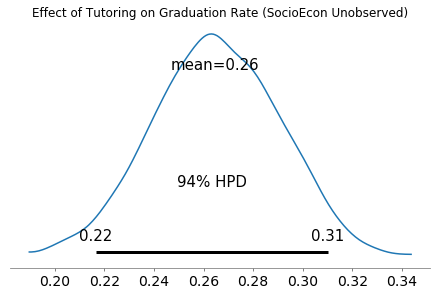

In [103]:
ax = pm.plot_posterior(mean_distrib_socio_econ_unobs)
ax[0].set_title('Effect of Tutoring on Graduation Rate (SocioEcon Unobserved)')

In [104]:

mean_distrib_socio_econ_obs = logistic(
         1 * traces_socio_and_frpl_observed['tutoring_to_grad_coeff'] + \
         df['socioeconomic_status_scaled'] * \
         traces_socio_and_frpl_observed['socioecon_to_grad_coeff'] + \
         traces_socio_and_frpl_observed['grad_alpha']
    ) - logistic(
         0 * traces_socio_and_frpl_observed['tutoring_to_grad_coeff'] + \
         df['socioeconomic_status_scaled'] * \
         traces_socio_and_frpl_observed['socioecon_to_grad_coeff'] + \
         traces_socio_and_frpl_observed['grad_alpha']
    )

# ax = pm.plot_posterior(mean_distrib_socio_econ_obs)
# ax[0].set_title('Effect of Tutoring on Graduation Rate (SocioEcon Observed)')

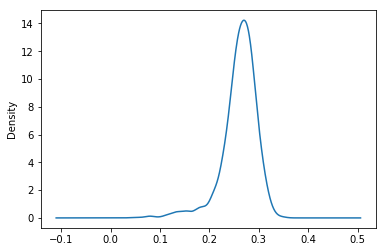

In [105]:
pd.Series(mean_distrib_socio_econ_obs).plot.kde()

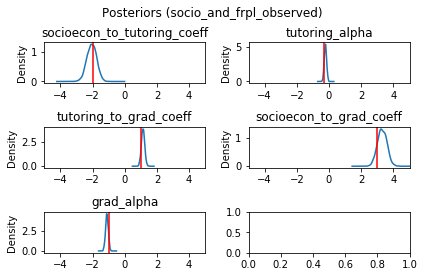

In [106]:
plot(prior_or_posterior=traces_socio_and_frpl_observed, true_values=true_values, title="Posteriors (socio_and_frpl_observed)")

The parameter of interest is 

/Users/eugaddan/miniconda3/envs/causal-inf-experiments/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12af23850>],
      dtype=object)

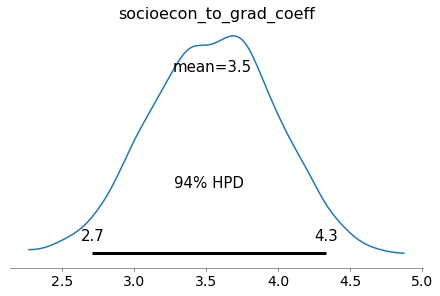

In [107]:
pm.plot_posterior(traces_with_measurement_error, varnames=['socioecon_to_grad_coeff'])